# Deep Neural Network from Scratch

Implementing a deep neural network from scratch using numpy only.


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve, average_precision_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)


## Load data


In [57]:
data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
print(f"Shape: {data.shape}")
print(f"Fraud rate: {data['Class'].mean()*100:.3f}%")


Shape: (284807, 31)
Fraud rate: 0.173%


In [58]:
train_idx = int(len(data) * 0.70)
val_idx = int(len(data) * 0.85)

train_df = data.iloc[:train_idx].copy()
val_df = data.iloc[train_idx:val_idx].copy()
test_df = data.iloc[val_idx:].copy()

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 199364, Val: 42721, Test: 42722


In [59]:
feat_cols = [f'V{i}' for i in range(1, 29)] + ['Amount']

X_tr = train_df[feat_cols].values
X_v = val_df[feat_cols].values
X_te = test_df[feat_cols].values

y_tr = train_df['Class'].values
y_v = val_df['Class'].values
y_te = test_df['Class'].values


In [60]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_tr)
X_val = scaler.transform(X_v)
X_test = scaler.transform(X_te)

print(f"Features: {X_train.shape[1]}")

Features: 29


## Neural network implementation


In [61]:
class NeuralNet:
    def __init__(self, layer_sizes, learning_rate=0.001, reg_lambda=0.0001):
        self.layer_sizes = layer_sizes
        self.lr = learning_rate
        self.reg = reg_lambda
        self.weights = []
        self.biases = []
        
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2.0 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return (x > 0).astype(float)
    
    def sigmoid(self, x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)
    
    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        
        a = X
        for i in range(len(self.weights) - 1):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            a = self.relu(z)
            self.activations.append(a)
        
        z_out = np.dot(a, self.weights[-1]) + self.biases[-1]
        self.z_values.append(z_out)
        a_out = self.sigmoid(z_out)
        self.activations.append(a_out)
        
        return a_out
    
    def backward(self, X, y, output, pos_weight=1.0):
        m = X.shape[0]
        y_reshaped = y.reshape(-1, 1)
        
        sample_weights = y_reshaped * pos_weight + (1 - y_reshaped)
        dA = (output - y_reshaped) * sample_weights
        
        dW = []
        db = []
        
        for i in reversed(range(len(self.weights))):
            if i == len(self.weights) - 1:
                dZ = dA * self.sigmoid_derivative(self.z_values[i])
            else:
                dZ = dA * self.relu_derivative(self.z_values[i])
            
            dW_i = np.dot(self.activations[i].T, dZ) / m
            db_i = np.sum(dZ, axis=0, keepdims=True) / m
            
            dW.insert(0, dW_i)
            db.insert(0, db_i)
            
            if i > 0:
                dA = np.dot(dZ, self.weights[i].T)
        
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * (dW[i] + self.reg * self.weights[i])
            self.biases[i] -= self.lr * db[i]
    
    def compute_loss(self, y_true, y_pred, pos_weight=1.0):
        m = y_true.shape[0]
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        
        y_true_reshaped = y_true.reshape(-1, 1)
        
        pos_term = y_true_reshaped * np.log(y_pred) * pos_weight
        neg_term = (1 - y_true_reshaped) * np.log(1 - y_pred)
        cross_entropy = -np.mean(pos_term + neg_term)
        
        l2_reg = 0
        for w in self.weights:
            l2_reg += np.sum(w ** 2)
        l2_reg = self.reg * l2_reg / (2 * m)
        
        return cross_entropy + l2_reg
    
    def predict(self, X):
        return self.forward(X)
    
    def predict_classes(self, X, threshold=0.5):
        probs = self.predict(X)
        return (probs >= threshold).astype(int).flatten()


## Training function


In [62]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=256, pos_weight=1.0, verbose=True):
    train_losses = []
    val_losses = []
    n_samples = X_train.shape[0]
    
    for epoch in range(epochs):
        indices = np.random.permutation(n_samples)
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        epoch_loss = 0
        n_batches = 0
        
        for i in range(0, n_samples, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            output = model.forward(X_batch)
            loss = model.compute_loss(y_batch, output, pos_weight)
            epoch_loss += loss
            n_batches += 1
            
            model.backward(X_batch, y_batch, output, pos_weight)
        
        avg_train_loss = epoch_loss / n_batches
        
        val_output = model.predict(X_val)
        val_loss = model.compute_loss(y_val, val_output, pos_weight)
        
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)
        
        if verbose and (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    return train_losses, val_losses

## Create and train model


In [63]:
input_dim = X_train.shape[1]
layer_config = [input_dim, 128, 64, 32, 1]

nn = NeuralNet(layer_config, learning_rate=0.001, reg_lambda=0.0001)
print(f"Model created with layers: {layer_config}")


Model created with layers: [29, 128, 64, 32, 1]


In [64]:
pos_weight = (y_tr == 0).sum() / (y_tr == 1).sum()
print(f"Class imbalance weight: {pos_weight:.2f}")

train_losses, val_losses = train_model(
    nn, X_train, y_tr, X_val, y_v,
    epochs=50, batch_size=256, pos_weight=pos_weight, verbose=True
)


Class imbalance weight: 518.18
Epoch 5/50 - Train Loss: 0.642892, Val Loss: 0.412439
Epoch 10/50 - Train Loss: 0.473723, Val Loss: 0.352512
Epoch 15/50 - Train Loss: 0.336247, Val Loss: 0.323341
Epoch 20/50 - Train Loss: 0.307644, Val Loss: 0.306293
Epoch 25/50 - Train Loss: 0.287031, Val Loss: 0.292924
Epoch 30/50 - Train Loss: 0.270481, Val Loss: 0.283091
Epoch 35/50 - Train Loss: 0.257420, Val Loss: 0.277772
Epoch 40/50 - Train Loss: 0.247136, Val Loss: 0.278084
Epoch 45/50 - Train Loss: 0.239223, Val Loss: 0.278808
Epoch 50/50 - Train Loss: 0.232187, Val Loss: 0.280146


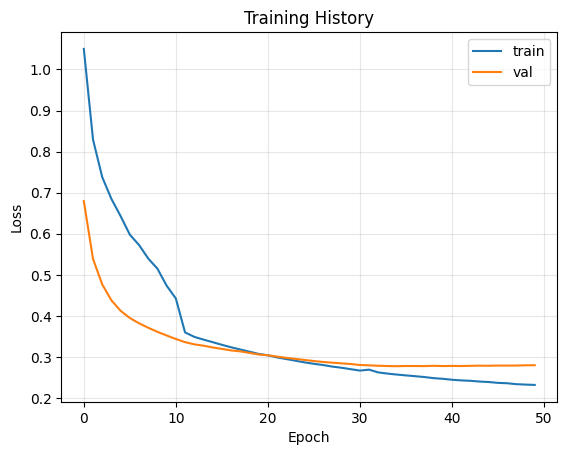

In [71]:
plt.figure()
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.title('Training History')
plt.show()

## Evaluate on test set


In [66]:
y_pred_proba = nn.predict(X_test).flatten()
y_pred = nn.predict_classes(X_test, threshold=0.5)

print(f"Accuracy: {accuracy_score(y_te, y_pred):.4f}")
print(f"Precision: {precision_score(y_te, y_pred, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_te, y_pred):.4f}")
print(f"F1: {f1_score(y_te, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_te, y_pred_proba):.4f}")
print(f"PR-AUC: {average_precision_score(y_te, y_pred_proba):.4f}")


Test Results:
Accuracy: 0.9843
Precision: 0.0599
Recall: 0.8077
F1: 0.1116
ROC-AUC: 0.9540
PR-AUC: 0.7184



Confusion Matrix:


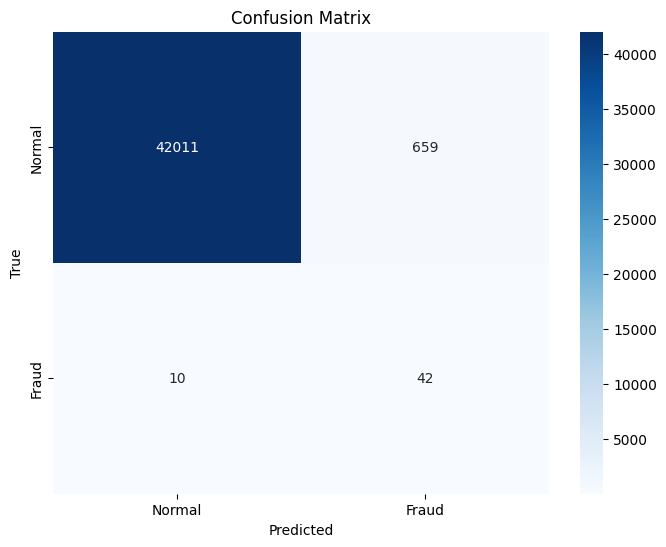

In [73]:
cm = confusion_matrix(y_te, y_pred)

print("\nConfusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

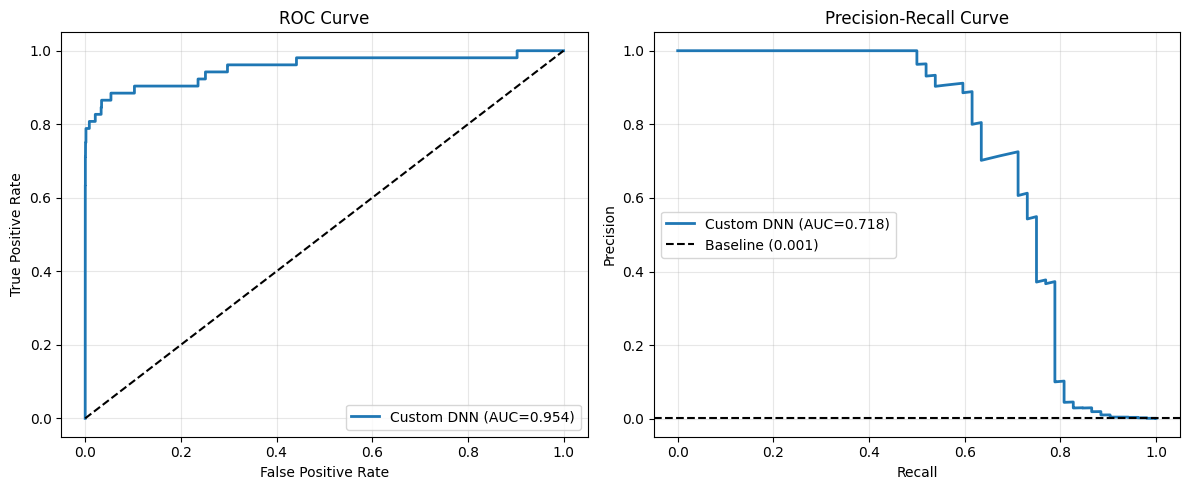

In [68]:
fpr, tpr, _ = roc_curve(y_te, y_pred_proba)
roc_auc = roc_auc_score(y_te, y_pred_proba)

precision, recall, _ = precision_recall_curve(y_te, y_pred_proba)
pr_auc = average_precision_score(y_te, y_pred_proba)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'Custom DNN (AUC={roc_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'Custom DNN (AUC={pr_auc:.3f})', linewidth=2)
baseline = y_te.mean()
plt.axhline(y=baseline, color='k', linestyle='--', label=f'Baseline ({baseline:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Overfitting check


In [69]:
train_pred_proba = nn.predict(X_train).flatten()
train_pred = nn.predict_classes(X_train)

val_pred_proba = nn.predict(X_val).flatten()
val_pred = nn.predict_classes(X_val)

train_acc = accuracy_score(y_tr, train_pred)
val_acc = accuracy_score(y_v, val_pred)
test_acc = accuracy_score(y_te, y_pred)

train_f1 = f1_score(y_tr, train_pred)
val_f1 = f1_score(y_v, val_pred)
test_f1 = f1_score(y_te, y_pred)

print("Performance across splits:")
print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")
print(f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, Test F1: {test_f1:.4f}")

gap = train_acc - test_acc
print(f"\nTrain-Test gap: {gap:.4f}")
if gap > 0.05:
    print("Warning: Overfitting!")
else:
    print("Generalization looks okay.")


Performance across splits:
Train Acc: 0.9846, Val Acc: 0.9819, Test Acc: 0.9843
Train F1: 0.1933, Val F1: 0.1164, Test F1: 0.1116

Train-Test gap: 0.0002
Generalization looks okay.


In [70]:
results = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'PR-AUC'],
    'Train': [
        accuracy_score(y_tr, train_pred),
        precision_score(y_tr, train_pred, zero_division=0),
        recall_score(y_tr, train_pred),
        f1_score(y_tr, train_pred),
        roc_auc_score(y_tr, train_pred_proba),
        average_precision_score(y_tr, train_pred_proba)
    ],
    'Val': [
        accuracy_score(y_v, val_pred),
        precision_score(y_v, val_pred, zero_division=0),
        recall_score(y_v, val_pred),
        f1_score(y_v, val_pred),
        roc_auc_score(y_v, val_pred_proba),
        average_precision_score(y_v, val_pred_proba)
    ],
    'Test': [
        accuracy_score(y_te, y_pred),
        precision_score(y_te, y_pred, zero_division=0),
        recall_score(y_te, y_pred),
        f1_score(y_te, y_pred),
        roc_auc_score(y_te, y_pred_proba),
        average_precision_score(y_te, y_pred_proba)
    ]
})

print("\nFull results table:")
print(results.to_string(index=False))



Full results table:
   Metric    Train      Val     Test
 Accuracy 0.984551 0.981882 0.984341
Precision 0.107455 0.062195 0.059914
   Recall 0.960938 0.910714 0.807692
       F1 0.193295 0.116438 0.111554
  ROC-AUC 0.988291 0.966775 0.954049
   PR-AUC 0.785591 0.835446 0.718353
